# Lake Level and Discharge

**Here we analyse the datas from Geoprevent**

- Lake level was reccording using 2 pressure tranducers at different locations on the lake bottom (see Geoprevent website)
- Because there were dysfunctionement in pressure tranducers and because one sensor was out from water from 2nd August onward, we correct ourself the lake level times series manually and reconstruct a single time series combining both sensors.
- The lake hypsometry is obtained from a UAV DEM acquired the 4th September 
- Discharge from the melt input from the lake watershed (filling the lake) is calculated from a temperature index model by Hock et al 1999, calibrated on GLAMOS data for Plaine Morte
- By combining all this, we infer the lake discharge at daily resolution

In [1]:
using PyPlot
using Statistics
using NBInclude
@nbinclude("helper-functions.ipynb");

### Flight references used to acquire 2018 and 2019 DEMs

Flight2018: Swisstopo flight 88a3fbb06f. Web: https://s.geo.admin.ch/88a3fbb06f accesed: 2021:04:7


Flight2019: Swisstopo flight 88a3fb2cb1. Web: https://s.geo.admin.ch/88a3fb2cb1} accesed: 2021:04:7


## Lake level Time Series $dh/dt$ from `Rohdaten.csv` 
**(https://data.geopraevent.ch/login.php)**

**`level1` and `level2` in `Rohdaten.csv` are corrected and calibrated with independant GPS measurements. Then the two time series are gathered to make one single time series**

In [2]:
using Dates
using DelimitedFiles: readdlm 
d,head = readdlm(path_lake*"Rohdaten_2019.csv", ';', header=true);
lake = Dict{Symbol,Any}() 
fmtdt = "dd/mm/yyyy H:M:S"
for i in 2:5
d[:,i] = [s=="" ? missing : s isa AbstractString ? parse(Float64, replace(s, ","=>".")) : Float64(s) for s in d[:,i]]
end
z1=2725.46; #altitude of Pegel Faverges 1 pressure sensor 
z2=2701.98;  #altitude of Pegel Faverges 2 pressure sensor
t2=reverse([DateTime(dd, fmtdt) for dd in d[:,1]]);
lake[:t] = reverse([DateTime(dd, fmtdt) for dd in d[:,1]]);
lake[:l1]=boxcar(z1.+reverse(d[:,2]),5);  
lake[:temp1]=reverse(d[:,3]);
lake[:temp2]=reverse(d[:,4]);
lake[:l2]=boxcar(reverse(0.9.+z2.+d[:,5]),5); #+0.9 to match the two time series, error in calibration 1 or 2 ??

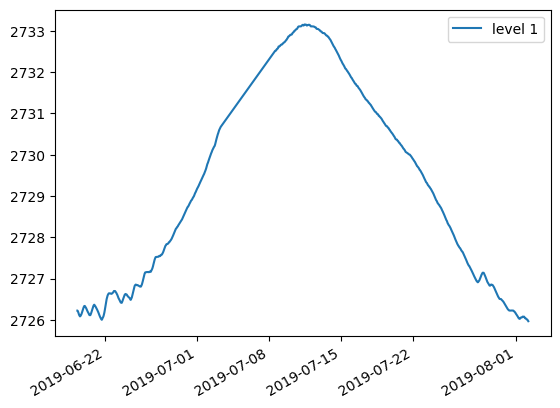

PyObject <matplotlib.legend.Legend object at 0x000000004B37FA20>

In [3]:
#Clean level 1
purge=vcat(collect(2011:2761),collect(6323:length(lake[:t])));
deleteat!(lake[:l1],purge);
deleteat!(lake[:t],purge);
pygui(false)
fig=figure()
plot(lake[:t],lake[:l1], label="level 1")
fig.autofmt_xdate(bottom=0.2,rotation=30,ha="right")
legend()

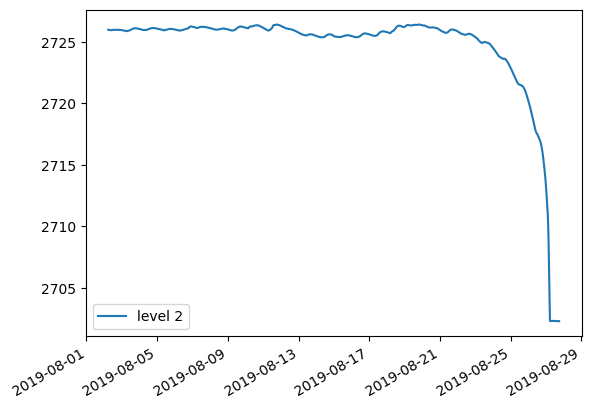

PyObject <matplotlib.legend.Legend object at 0x000000004B41AF60>

In [4]:
#Clean level 2
purge=vcat(collect(1:6323),collect(10000:length(lake[:l2])));
deleteat!(lake[:l2],purge);
deleteat!(t2,purge);
for i in 1745:length(lake[:l2])
    lake[:l2][i]=lake[:l2][i].-0.7  #new sensor location the 14/08 at 11:50: 70cm of rope length change
end
purge=vcat(collect(887:900),collect(1739:1754)); # the two relocation
deleteat!(lake[:l2],purge);
deleteat!(t2,purge);

pygui(false)
fig=figure()
plot(t2,lake[:l2], label="level 2")
fig.autofmt_xdate(bottom=0.2,rotation=30,ha="right")
legend()

### One single lake level time series 

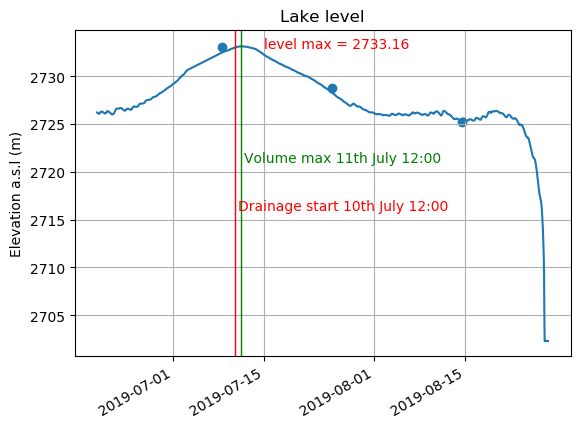

PyObject <matplotlib.collections.PathCollection object at 0x000000004B5035F8>

In [5]:
pygui(false)
h=vcat(lake[:l1],lake[:l2])
h=round.(h;digits=2);
t=vcat(lake[:t],t2)
fig=figure()
plot(t,h)
title("Lake level")
ylabel("Elevation a.s.l (m)")
fig.autofmt_xdate(bottom=0.2,rotation=30,ha="right")
grid(true)
axvline(x=DateTime(2019,7,10,12),linewidth=1,color="r")
axvline(x=DateTime(2019,7,11,12),linewidth=1,color="g")
text(DateTime(2019,7,12),2721,"Volume max 11th July 12:00",color="g",Fontsize=10)
text(DateTime(2019,7,11),2716,"Drainage start 10th July 12:00",color="r",Fontsize=10)
m = findmax(h)
text(DateTime(2019,7,15),2733,"level max = $(m[1])", color="r")

#control with dGPS point. But time in the day was unfortunately not reported. So we set noon
scatter([DateTime(2019,7,8, 12), DateTime(2019,7,25, 12),DateTime(2019,8,14, 12)], 
            [2733.04, 2728.77,2725.23], label = "dGPS measurements")


#savefig("C:/Users/christophe/Desktop/Christophe Ogier Home/Plaine Morte_Lac des Faverges/Datas/Lake_level/lakelevel.png")

## To store lake level $dh/dt$ in CSV file 

In [6]:
using DataFrames
using CSV
df=DataFrame(Date_Time =t, Elevation=h);
CSV.write(path_products*"Lake_level_corr_2019.csv",df, dateformat = "yyyy-mm-ddTH:M:S");

**At this stage, this lake level time series is sent to Matthias to run his model of lake discharge (taking $Q_{in}$ into account). Then all the outputs are sent back to here in `time_vol_2019.csv` and `discharge_2019.csv` (using 2018 DEM)**

# Lake Discharge =  $Q_{out}  = Q_{in} - A(h) \frac{d h}{dt}    $

 where $A$ is the lake area for a given elevation, $h$ lake level, $Q$ are the discharge into the lake and out.

Here we compute le lake discharge after 3 steps:

- Calcul of $Q_{in}$ from melt of the lake watershed
- Calcul of $dV/dt$ from lake level time series $dh/dt$ and lake hypsometrie $A(h)$
- Calcul of lake discharge with $Q_{out} = Q_{in} - A(h)*dh/dt $




## Lake input $Q_{in}$

**$Q_{in}$ is obtained from a temperature index melt model (hock 1999) calibrated on the GLAMOS data for PLM, using the 2019 DEM**

In [7]:
using Dates
using DelimitedFiles: readdlm 
d,head = readdlm(path_lake*"discharge_2019_DEM2019.dat", ';', header=true);
Qin = Dict{Symbol,Any}() 

purge=collect(1:94);   #DOY 0 is 1/1/2019 !!
Qin[:glacier]=deleteat!(d[:,4],purge)
Qin[:lake]=deleteat!(d[:,5],purge)
Qin[:lake_off]=deleteat!(d[:,6],purge)  
Qin[:lake_cum]=deleteat!(d[:,7],purge)
Qin[:lake_off_cum]=deleteat!(d[:,8],purge)
Qin[:t]=collect(DateTime(2019,1,1):Day(1):DateTime(2019,10,1));

**$Q_{in2}$ computed with the DEM acquired in Sept 2018 (better estimation)**

In [8]:
using Dates
using DelimitedFiles: readdlm 
d,head = readdlm(path_lake*"discharge_2019_DEM2018.dat", ';', header=true);
Qin_2 = Dict{Symbol,Any}() 

purge=collect(1:94);
Qin_2[:glacier]=deleteat!(d[:,4],purge)
Qin_2[:lake]=deleteat!(d[:,5],purge)
Qin_2[:lake_off]=deleteat!(d[:,6],purge)  
Qin_2[:lake_cum]=deleteat!(d[:,7],purge)
Qin_2[:lake_off_cum]=deleteat!(d[:,8],purge)
Qin_2[:t]=collect(DateTime(2019,1,1):Day(1):DateTime(2019,10,1));

### $Q_{in3}$ from 2018 DEM and re-run by Matthias the 11.12.2020

In [9]:
d,head = readdlm(path_lake*"discharge_modelled_2019_BIS.dat", ';', header=true);
Qin_3 = Dict{Symbol,Any}() 

purge=collect(1:94);
Qin_3[:lake]=deleteat!(d[:,5],purge)
Qin_3[:lake_cum]=deleteat!(d[:,7],purge)
Qin_3[:t]=collect(DateTime(2019,1,1):Day(1):DateTime(2019,10,1));

### Plot $Q_{in}$ 

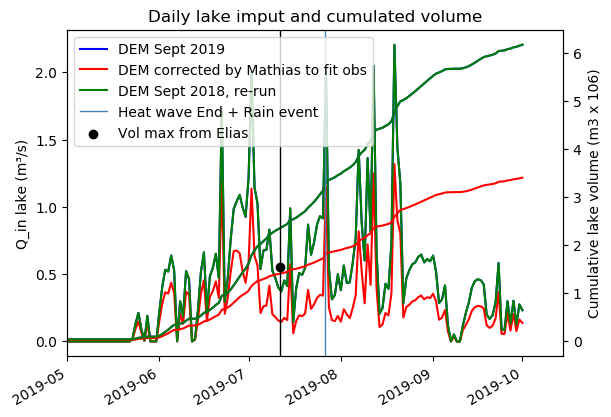

PyObject <matplotlib.legend.Legend object at 0x0000000052666BE0>

In [10]:
pygui(false)
fig=figure()
ax = gca()
plot(Qin[:t],Qin[:lake], color = "blue")
plot(Qin_2[:t],Qin_2[:lake], color = "r")
plot(Qin_3[:t],Qin_3[:lake], color = "green")
fig.autofmt_xdate(bottom=0.2,rotation=30,ha="right")
ylabel("Q_in lake (m³/s)")
title("Daily lake imput and cumulated volume")
xlim(DateTime(2019,5,1))
#text(DateTime(2019,5,15),0.6,"Coeff = $(round(coeff_reduc,digits=2))",color="red")
ax2 = ax.twinx()
plot(Qin[:t],Qin[:lake_cum]./1e6,color="b",label="DEM Sept 2019")
plot(Qin_2[:t],Qin_2[:lake_cum]./1e6,color="r",label="DEM corrected by Mathias to fit obs")
plot(Qin_3[:t],Qin_3[:lake_cum]./1e6,color="green",label="DEM Sept 2018, re-run")
scatter(DateTime(2019,7,11,12),1553618.07/1e6,color="black",label="Vol max from Elias")
ylabel("Cumulative lake volume (m3 x 106)")
#axvline(x=DateTime(2019,7,10,12),linewidth=1,color="r")
axvline(x=DateTime(2019,7,11,12),linewidth=1,color="black")
axvline(x=DateTime(2019,7,26,18),linewidth=1,color="steelblue", label="Heat wave End + Rain event")
legend()


**$Q_{in3}$ cumul doesn't match well the lake volume the 10 July (maximum), but we can expect that a substancial part of the running water did actually not fill the lake, but disapear in moulins (or other englacial path) before reaching the lake**

### Calibration of $Q_{in}$ and $Q_{in2}$ to match volume max from DEM2019

It appears that $Q_{in}$ overestimate the lake filling when we compare with our observations. So we simply apply a reduction coefficient on all the $Q_{in}$ time series to match the obseravtion (which is the volume max of the lake)

In [11]:
##Calibration to match real lake volume##

max_real = 1553618.07 # m³  OBTAINED FROM ELIAS DEM
max_model= Qin[:lake_cum][findfirst(x -> x == DateTime(2019,7,11), Qin[:t])]
coeff_reduc = max_model/max_real
Qin[:lake] = Qin[:lake]./coeff_reduc;
Qin[:lake_cum] = Qin[:lake_cum]./coeff_reduc;


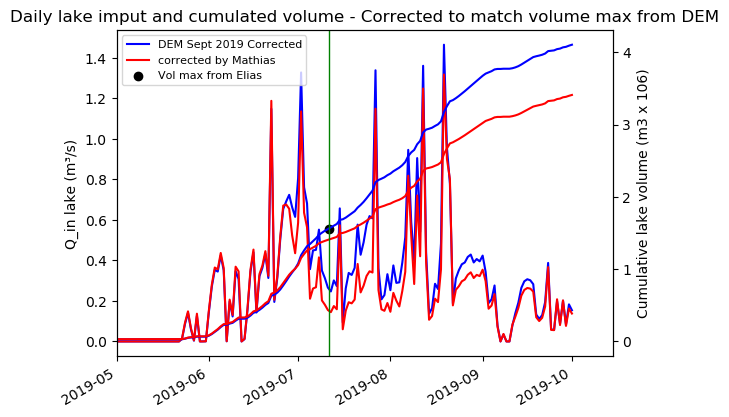

PyObject <matplotlib.legend.Legend object at 0x00000000526CC828>

In [12]:
pygui(false)
fig=figure()
ax = gca()
plot(Qin[:t],Qin[:lake], color = "b")
plot(Qin_2[:t],Qin_2[:lake], color = "r")
fig.autofmt_xdate(bottom=0.2,rotation=30,ha="right")
ylabel("Q_in lake (m³/s)")
title("Daily lake imput and cumulated volume - Corrected to match volume max from DEM")
xlim(DateTime(2019,5,1))
#text(DateTime(2019,5,15),0.6,"Coeff = $(round(coeff_reduc,digits=2))",color="red")
ax2 = ax.twinx()
plot(Qin[:t],Qin[:lake_cum]./1e6,color="b",label="DEM Sept 2019 Corrected")
plot(Qin_2[:t],Qin_2[:lake_cum]./1e6,color="r",label="corrected by Mathias")
scatter(DateTime(2019,7,11,12),1553618.07/1e6,color="black",label="Vol max from Elias")
ylabel("Cumulative lake volume (m3 x 106)")
#axvline(x=DateTime(2019,7,10,12),linewidth=1,color="r")
axvline(x=DateTime(2019,7,11,12),linewidth=1,color="g")
legend(fontsize=8)

**According to Matthias' model runs, $Q_{in3}$ provide a better estimate when comparing with observation (see mail 11 dec 2020)** 

**In consequence we will take $Q_{in3}$ in our next calculs**

## Lake Volume Change time series $dV/dt = A(h)*dh/dt $

**with**:

- **$A(h)$ determined by DEM 2018 and 2019 (respectively under- and over-estimation because of melt)**
- **$dh/dt $ from lake level time series**


### Import $dh/dt$ (`level`),  volume (`V`) and $dV/dt$ (`dv`) from CSV files

### using 2019 DEM

In [13]:
using Dates
using DelimitedFiles: readdlm 
d,head = readdlm(path_lake*"time_vol_2019_DEM2019.dat", ';', header=true);
dv = Dict{Symbol,Any}() 
#really bad way to parse time I guess...
dv[:y] = convert(Array{Int64,1}, d[:,1])
dv[:m] = convert(Array{Int64,1}, d[:,2])
dv[:d] = convert(Array{Int64,1}, d[:,3])
dv[:H] = convert(Array{Int64,1}, d[:,4])
dv[:M] = convert(Array{Int64,1}, d[:,5])
dv[:S] = convert(Array{Int64,1}, d[:,6]);
dv[:time] = [string(y,"/",m,"/",d," ",H,":",M,":",S) for (y,m,d,H,M,S) in zip(dv[:y],dv[:m],dv[:d],dv[:H],dv[:M],dv[:S])]
dv[:t]=[]
fmdt = "yyyy/mm/dd H:M:S"
for i in eachindex(dv[:time]) 
    push!(dv[:t], DateTime(dv[:time][i], fmdt))
end
dv[:level] = d[:,7]
dv[:volume] = d[:,8]
dv[:dv] = -d[:,9];

### using 2018 DEM 

In [14]:
using Dates
using DelimitedFiles: readdlm 
d,head = readdlm(path_lake*"time_vol_2019_DEM2018.dat", ';', header=true);
dv_2 = Dict{Symbol,Any}() 
#really bad way to parse time I guess...
dv_2[:y] = convert(Array{Int64,1}, d[:,1])
dv_2[:m] = convert(Array{Int64,1}, d[:,2])
dv_2[:d] = convert(Array{Int64,1}, d[:,3])
dv_2[:H] = convert(Array{Int64,1}, d[:,4])
dv_2[:M] = convert(Array{Int64,1}, d[:,5])
dv_2[:S] = convert(Array{Int64,1}, d[:,6]);
dv_2[:time] = [string(y,"/",m,"/",d," ",H,":",M,":",S) for (y,m,d,H,M,S) in zip(dv_2[:y],dv_2[:m],dv_2[:d],dv_2[:H],dv_2[:M],dv_2[:S])]
dv_2[:t]=[]
fmdt = "yyyy/mm/dd H:M:S"
for i in eachindex(dv_2[:time])
    push!(dv_2[:t], DateTime(dv_2[:time][i], fmdt))
end
dv_2[:level] = d[:,7]
dv_2[:volume] = d[:,8]
dv_2[:dv] = -d[:,9];

### Comparison of volume $V$ using 2018 or 2019 DEM 

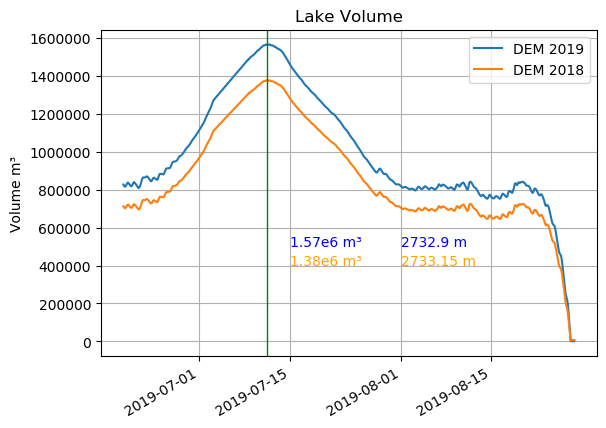

PyObject Text(2019-08-01 00:00:00, 400000, '2733.15 m')

In [15]:
pygui(false)
fig=figure()
plot(dv[:t],boxcar(dv[:volume],0),label="DEM 2019")
plot(dv_2[:t],boxcar(dv_2[:volume],0), label="DEM 2018")
fig[:autofmt_xdate](bottom=0.2,rotation=30,ha="right")  
#axvline(x=DateTime(2019,7,10,12),linewidth=1,color="r")
axvline(x=DateTime(2019,7,11,12),linewidth=1,color="g")
grid(true)
title("Lake Volume")
ylabel("Volume m³")
legend()
m = findmax(dv[:volume])[1]
m2 = findmax(dv_2[:volume])[1]
l = dv[:level][findmax(dv[:volume])[2]]
l2 = dv_2[:level][findmax(dv_2[:volume])[2]]

text(DateTime(2019,7,15),500000,"$(round(m, sigdigits = 3)) m³", color="blue")
text(DateTime(2019,7,15),400000,"$(round(m2, sigdigits = 3)) m³ ", color="orange")
text(DateTime(2019,8,1),500000,"$(round(l, digits = 3)) m", color="blue")
text(DateTime(2019,8,1),400000,"$(round(l2, digits = 3)) m", color="orange")




#### Using the 2019 DEM lead to an overestimated volume, because in September 2019 the lake catchement was bigger than in July 2019. Using the 2018 DEM lead to an underestimation. 

**Note: maximum volume using 2018 DEM in 1.38x10$^6$ m$^3$, maximum volume using 2019 DEM is 1.59x10$^6$ m$^3$. The number above (1.57x10$^6$ m$^3$) account for an lake level elevation of 2732.9m, that explains the volume difference.**

**The actual volume in constrained between these two values**

## Calcul of $dV/dt$

### Up-scale $dV/dt$ to daily resolution because $Q_{in}$ is daily at the best

**We are constrained to adapt $Q_{lake}$ at the lower resolution of the three terms (see Eq. 1), which is daily for $Q_{in}$**

In [16]:
@nbinclude("helper-functions.ipynb");

In [17]:
dv2 = upscale_timeseries(dv_2[:dv],dv_2[:t] ,"day");

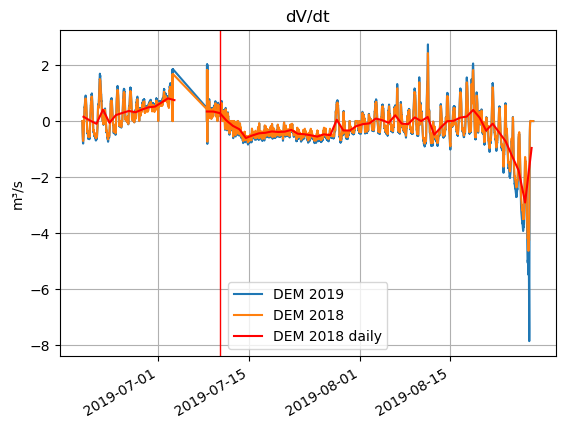

PyObject <matplotlib.legend.Legend object at 0x0000000054AC6E80>

In [18]:
pygui(false)
fig=figure()
plot(dv[:t],boxcar(dv[:dv],0),label="DEM 2019")
plot(dv[:t],boxcar(dv_2[:dv],0),label="DEM 2018")
plot(dv2[1],dv2[2], label="DEM 2018 daily", color = "red")

fig[:autofmt_xdate](bottom=0.2,rotation=30,ha="right")  
axvline(x=DateTime(2019,7,10,12),linewidth=1,color="r")
grid(true)
title("dV/dt")
ylabel("m³/s")
legend()

## Calcul of $Q_{lake} (=Q_{out}) = Q_{in} - A(h)*dh/dt$

**we use $Q_{in3}$**

In [19]:
#We are interested on the drainage period July-August only:
tstart = findfirst(x -> x == DateTime(2019,7,8), Qin_3[:t])
tend = findfirst(x -> x == DateTime(2019,8,27), Qin_3[:t])
qin_daily3 = Qin_3[:lake][tstart:tend]
t_qin = Qin_3[:t][tstart:tend];

tstart = findfirst(x -> x == DateTime(2019,7,8,12), dv2[1])
tend = findfirst(x -> x == DateTime(2019,8,27,12), dv2[1])
qout_daily2 = qin_daily3 .- dv2[2][tstart:tend];   #That is Q_out



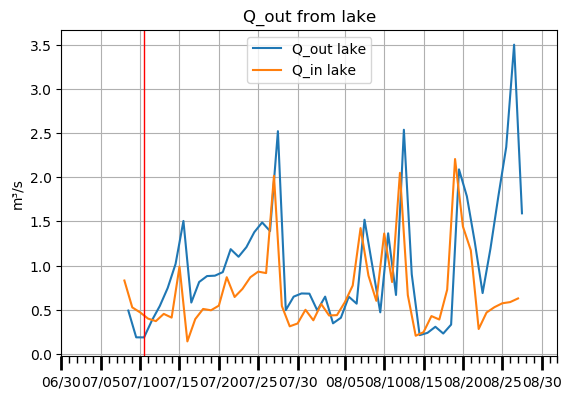

In [20]:
pygui(false)
fig=figure()
plot(dv2[1][tstart:tend],qout_daily2, label="Q_out lake")
plot(t_qin,qin_daily3, label ="Q_in lake")
axvline(x=DateTime(2019,7,10,12),linewidth=1,color="r")
grid(true)
title("Q_out from lake")
ylabel("m³/s")
xlim(DateTime(2019,6,30),DateTime(2019,9,1))
legend()
ax=gca()
majorformatter = matplotlib.dates.DateFormatter("%m/%d")
majorlocator   = matplotlib.dates.DayLocator(bymonthday=(5,10,15,20,25,30))
minorlocator   = matplotlib.dates.DayLocator(interval=1)
fig[:autofmt_xdate](bottom=0.2,rotation=0,ha="center")
ax.xaxis.set_major_formatter(majorformatter)
ax.xaxis.set_major_locator(majorlocator)
ax.xaxis.set_minor_locator(minorlocator)
ax.xaxis.set_tick_params(which="major",length=10,width=2)
ax.xaxis.set_tick_params(which="minor",length=5,width=1)

## To store $Q_{lake}$ (`qout_daily2`) in CSV file

In [21]:
using DataFrames
using CSV

df=DataFrame(Date_Time = dv2[1][tstart:tend], Discharge_lake = round.(qout_daily2, digits = 3) );
CSV.write(path_products*"discharge_lake_daily.csv",df ; dateformat = "yyyy-mm-ddTH:M:S");

# Hypsometry parametrization ($p_L$): What about the scaling between lake Volume and Elevation change ? 


**Raymond and Nolan 2000 estimate a linear decrease between lake volume $V_L$ and depth $h_L$ to overcome the no-information on lake bathymetry. Kingslake 2015 (following Clarke 1982, Ng and Bjornsson 2003) proposes the following parametrization:**

$$ \frac{h_L}{h_0}^{p_L} = \frac{V_L}{V_0} $$

with $V_0$ and $h_0$ are lake reference volume and depth at initial conditions.

Vertically walls are described by a parameter $p_L = 1$, bowl shaped lake by $1<p_L<3$, conic lake by $p_L = 3$ and lake shape lie a musical horn by $p_L>3$ (Clarke, 1982)

In [22]:
#from Elias mail 24-10-2019 and QGIS study (note that lake volume is only the main lake, it doe not take the canyon):
#h in meters (depth) and V in 10^3 cubic meters
hl,vl = 
[2733.15,2730,2725,2720,2715,2710,2705,2700].-2700,
[1553618.07,1198009.06,728389.65,374665.99,148831.20,37630.87,3932.00,473.26]./1000

h_ratio = hl/hl[1]
v_ratio = vl/vl[1];

#from 2018 DEM -> The one actually used to compute Qin and Qout
d,head = readdlm(path_lake*"time_vol_2019_DEM2018.dat", ';', header=true);
hl_2018=d[:,7].-minimum(d[:,7])
vl_2018=d[:,8]./1000;

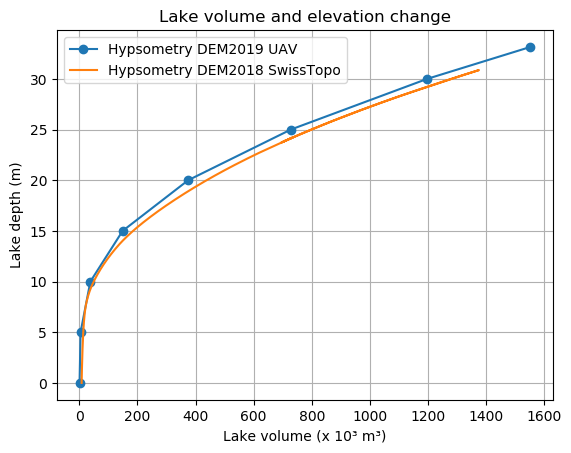

PyObject <matplotlib.legend.Legend object at 0x0000000059C049E8>

In [23]:
plot(vl,hl, marker="o", label="Hypsometry DEM2019 UAV")
plot(vl_2018,hl_2018, label="Hypsometry DEM2018 SwissTopo")
ylabel("Lake depth (m)")
xlabel("Lake volume (x 10³ m³)")
grid(true)
title("Lake volume and elevation change")
legend()

### Calculation of hypsometry parameter $p_L$ and comparison with other studies

In [24]:
#Our study
#We actually take hl and vl instead of hl/h0 and vl/v0. Indeed this lead to the same scaling.
using LsqFit
fn(h_ratio, p) = p[1]*h_ratio.^p[2] 
para_weights = [0.1,1] # equal weights to parameters
fit = curve_fit(fn, h_ratio, v_ratio, para_weights)
# to get margin of error and confidence interval of each parameter at 5% significance level:
errors = margin_error(fit, 1-0.95);
confidence_inter = confidence_interval(fit, 0.05)
# to get standard error of each parameter:
sigma = stderror(fit)
#readouts =  range(0, 33, step=1)
#plot((fn(readouts, fit.param)),readouts)
fit.param[1]
pL = round(fit.param[2], digits = 2) #pL
pL_err = round(sigma[2], digits= 2)

0.05

In [25]:
sigma

2-element Array{Float64,1}:
 0.008678446960955294
 0.0543494510950516

In [26]:
#Vertical walls lake:
v = f_vertical(h) = h

#Cone shaped
v = f_cone(h) = h.^3

#Horn shaped
v = f_horn(h) = h.^5

f_horn (generic function with 1 method)

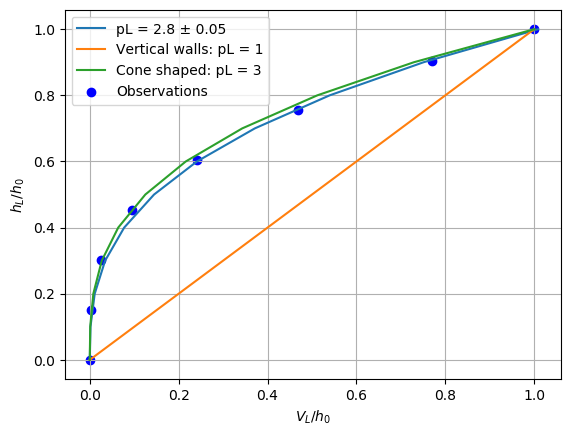

PyObject <matplotlib.legend.Legend object at 0x0000000059C65E80>

In [27]:
scatter(v_ratio,h_ratio, marker="o", color= "b", label="Observations")
readouts =  range(0, 1, step=0.1)
#our study
plot((fn(readouts, fit.param)),readouts, label="pL = $pL ± $pL_err")
#vertical walls
plot(f_vertical(readouts),readouts, label="Vertical walls: pL = 1")
#cone shape
plot(f_cone(readouts),readouts, label="Cone shaped: pL = 3")
#Musical horn shape
#plot(f_horn(readouts),readouts, label="Musical horn shaped: pL = 5")
ylabel(L"h_L/h_0") 
xlabel(L"V_L/h_0")
grid(true)
legend()

# Figure 2. Peak discharge from 2012 to 2020

**Note:** in the following files Q_in into lake was not taking into calculations. Because in all cases from 2012 to 2018 the lake elevation change was much larger than the imput. This is not the case in 2019, where Q_in is calculated (see above) 

In [28]:
using Dates
using DelimitedFiles: readdlm 

#The idea here is to store all dictionnary (that countains time, lake level, volume and discharge for a given
# year) in an array of 8 eleemts 8 (=8 years)
years = ["2012","2013","2014","2015","2016","2017","2018","2019"]
time_vol_y = []
for i in 1:8 #from 2012 to 2019 
    d,head = readdlm(path_lake*"time_vol_$(years[i]).csv", ';', header=true);
    out = Dict{Symbol,Any}() 
    #heavy way to parse time I guess...
    out[:y] = convert(Array{Int64,1}, d[:,1])
    out[:m] = convert(Array{Int64,1}, d[:,2])
    out[:d] = convert(Array{Int64,1}, d[:,3])
    out[:H] = convert(Array{Int64,1}, d[:,4])
    out[:M] = convert(Array{Int64,1}, d[:,5])
    out[:S] = convert(Array{Int64,1}, d[:,6])
    #we want to compare between season, so "normalize" the year
    out[:time] = [string(m,"/",d," ",H,":",M,":",S) for (m,d,H,M,S) in zip(out[:m],out[:d],out[:H],out[:M],out[:S])]
    out[:t]=[]
    fmdt = "mm/dd H:M:S"  
    for i in eachindex(out[:time])
        push!(out[:t], DateTime(out[:time][i], fmdt))
    end
    out[:level]=d[:,7]
    out[:vol]=d[:,8]
    out[:q]=d[:,9];
    push!(time_vol_y, out)
end

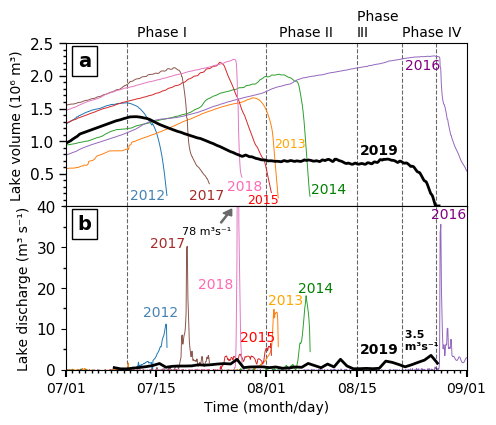

In [29]:
#plot

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 11,
        "axes.labelsize" => 10,
        "xtick.labelsize" => 10,
        "ytick.labelsize" => 11,
        "legend.fontsize" => 11,
)
merge!(rcParams, font0)


pygui(false)

fig = figure()
figsize=(15,8)

subplots_adjust(hspace=0.0) # Set the vertical spacing between axes
spec = fig.add_gridspec(2, 2, width_ratios=[8,1],height_ratios=[1,1])

##Lake volume
ax1 = subplot(spec[1, 1]) # Create the 1st axis of a 3x1 array of axes

for i in 1:7 #2019 is taken from the corrections above
    plot(time_vol_y[i][:t],time_vol_y[i][:vol]./10^6, linewidth=0.7,label="$(time_vol_y[i][:y][1])")    
end
#2019 -> We applied .-Year(2018) to compare with others years (set to 0001)

plot((dv_2[:t].-Year(2018)),dv_2[:volume]./10^6, linewidth=2, color="black", label="2019") 

ylabel("Lake volume (10⁶ m³)")
ylim(0,2.5)

my = matplotlib.ticker.MultipleLocator(0.1) # Define interval of minor ticks
My = matplotlib.ticker.MultipleLocator(0.5)
ax1.yaxis.set_minor_locator(my) # Set interval of minor ticks
ax1.yaxis.set_major_locator(My) 
ax1.yaxis.set_tick_params(which="major",length=5,width=1)
ax1.yaxis.set_tick_params(which="minor",length=2.5,width=1)
plt.yticks(0.5:0.5:2.5) #for yticks to work: AFTER set_tick_parameter and with "plt." attribution

#Phases
lw = 0.8 #linewidth
alpha=0.6 #transparancy
axvline(x=DateTime(1,7,10,12),linestyle="--",alpha=alpha,linewidth=lw,color="black",zorder=-1)
axvline(x=DateTime(1,8,1),linestyle="--",alpha=alpha,linewidth=lw,color="black",zorder=-1)
axvline(x=DateTime(1,8,15),linestyle="--",alpha=alpha,linewidth=lw,color="black",zorder=-1)
axvline(x=DateTime(1,8,22),linestyle="--",alpha=alpha,linewidth=lw,color="black",zorder=-1)
axvline(x=DateTime(1,8,27,6),linestyle="--",alpha=alpha,linewidth=lw,color="black",zorder=-1)
#text
text(DateTime(1,7,12),2.6,"Phase I", fontsize = 10)
text(DateTime(1,8,3), 2.6,"Phase II", fontsize = 10)
text(DateTime(1,8,15), 2.6,"Phase 
III", fontsize = 10)
text(DateTime(1,8,22), 2.6,"Phase IV", fontsize = 10)
ax1.text(0.03, 0.95, "a", transform=ax1.transAxes, ha="left", va="top", weight="bold",fontsize=14
, bbox=Dict(:boxstyle=>"square",:facecolor=>"white", :alpha=>1))

#legend in text
text(DateTime(1,7,11), 0.1,"2012",color="steelblue",fontsize=10)
text(DateTime(1,7,20), 0.1,"2017",color="brown",fontsize=10)
text(DateTime(1,7,26), 0.25,"2018",color="hotpink",fontsize=10)
text(DateTime(1,7,29), 0.05,"2015",color="red",fontsize=9)
text(DateTime(1,8,2,6), 0.9,"2013",color="orange",fontsize=9)
text(DateTime(1,8,8), 0.2,"2014",color="green",fontsize=10)
text(DateTime(1,8,15,12), 0.8,"2019",color="black",fontsize=10,weight="bold")
text(DateTime(1,8,22,12), 2.1,"2016",color="purple",fontsize=10)

#legend(bbox_to_anchor=[1,0.5],loc=2,borderaxespad=1,  fontsize=9)


##lake discharge
ax2 = subplot(spec[2, 1], sharex=ax1)
for i in 1:7 #2019 is taken from the corrections above
    plot(time_vol_y[i][:t],boxcar(time_vol_y[i][:q],6),linewidth=0.7)    
end
#2019
plot(dv2[1][tstart:tend].-Year(2018),qout_daily2, linewidth=2, color="black") #tsart and tend are here to shorten the time serie and match qout2

ylim(0.0,40)
#yticks(0:1:35)
ylabel("Lake discharge (m³ s⁻¹)")
xlabel("Time (month/day)")

xlim(DateTime(1,7,1),DateTime(1,9,1))
ax2.text(0.03, 0.95, "b", transform=ax2.transAxes, ha="left", va="top", weight="bold",fontsize=14
    , bbox=Dict(:boxstyle=>"square",:facecolor=>"white", :alpha=>1)) #BOX around letters

my = matplotlib.ticker.MultipleLocator(5)
ax2.yaxis.set_minor_locator(my)
ax2.yaxis.set_tick_params(which="minor",length=2.5,width=1)

majorformatter = matplotlib.dates.DateFormatter("%m/%d")  #b for monthname 
majorlocator   = matplotlib.dates.DayLocator(bymonthday=(1,15))
minorlocator   = matplotlib.dates.DayLocator(interval=1)
fig[:autofmt_xdate](bottom=0.2,rotation=0,ha="center")

ax2.xaxis.set_major_formatter(majorformatter)
ax2.xaxis.set_major_locator(majorlocator)
ax2.xaxis.set_minor_locator(minorlocator)
ax2.xaxis.set_tick_params(which="major",length=5,width=1.5)
ax2.xaxis.set_tick_params(which="minor",length=2.5,width=1)

#arrow
arrow(DateTime(1,7,25), 36, 1, 2, width=0.2,head_length=1.5,head_width=1.5,color="dimgrey")
text(DateTime(1,7,19), 33,"78 m³s⁻¹",color="black",fontsize=8)
text(DateTime(1,8,21,20), 5," 3.5 
 m³s⁻¹",color="black",fontsize=8,weight="bold")

#legend in text
text(DateTime(1,7,13), 13,"2012",color="steelblue",fontsize=10)
text(DateTime(1,7,14), 30,"2017",color="brown",fontsize=10)
text(DateTime(1,7,21,12), 20,"2018",color="hotpink",fontsize=10)
text(DateTime(1,7,28), 7,"2015",color="red",fontsize=10)
text(DateTime(1,8,1,8), 16,"2013",color="orange",fontsize=10)
text(DateTime(1,8,6), 19,"2014",color="green",fontsize=10)
text(DateTime(1,8,15,12), 4,"2019",color="black",fontsize=10,weight="bold")
text(DateTime(1,8,26,12), 37,"2016",color="purple",fontsize=10)



#Phases

axvline(x=DateTime(1,7,10,12),linestyle="--",alpha=alpha,linewidth=lw,color="black",zorder=-1)
axvline(x=DateTime(1,8,1),linestyle="--",alpha=alpha,linewidth=lw,color="black",zorder=-1)
axvline(x=DateTime(1,8,15),linestyle="--",alpha=alpha,linewidth=lw,color="black")
axvline(x=DateTime(1,8,22),linestyle="--",alpha=alpha,linewidth=lw,color="black")
axvline(x=DateTime(1,8,27,6),linestyle="--",alpha=alpha,linewidth=lw,color="black")

savefig(path_plots*"fig02.pdf",bbox_inches="tight") 

matplotlib.rcdefaults()

In [30]:
time_vol_y[8][:t];

In [31]:
# Discharge max 2019
maximum(qout_daily2)  #daily averaged


3.498788111888112

In [32]:
# discharge max 2018
maximum(boxcar(time_vol_y[7][:q],6))  #hourly averaged

77.9193076923077

# Plot Seminar November 2020

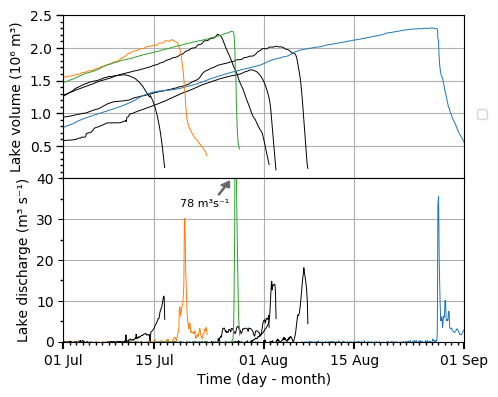

No handles with labels found to put in legend.


PyObject Text(0001-07-19 00:00:00, 33, '78 m³s⁻¹')

In [33]:
#plot
pygui(false)

fig = figure()
figsize=(15,8)

subplots_adjust(hspace=0.0) # Set the vertical spacing between axes
spec = fig.add_gridspec(2, 2, width_ratios=[8,1],height_ratios=[1,1])

##Lake volume
ax1 = subplot(spec[1, 1]) # Create the 1st axis of a 3x1 array of axes

for i in 1:4 #2019 is taken from the corrections above
    plot(time_vol_y[i][:t],time_vol_y[i][:vol]./10^6,color="black",linewidth=0.7)#,label="$(time_vol_y[i][:y][1])")    
end
for i in 5:7 #2019 is taken from the corrections above
    plot(time_vol_y[i][:t],time_vol_y[i][:vol]./10^6,linewidth=0.7)#,label="$(time_vol_y[i][:y][1])")    
end
#2019 -> We applied .-Year(2018) to compare with others years (set to 0001)

#plot((dv_2[:t].-Year(2018)),dv_2[:volume]./10^6, linewidth=2, color="black", label="2019") 

ylabel("Lake volume (10⁶ m³)")
ylim(0,2.5)

my = matplotlib.ticker.MultipleLocator(0.1) # Define interval of minor ticks
My = matplotlib.ticker.MultipleLocator(0.5)
ax1.yaxis.set_minor_locator(my) # Set interval of minor ticks
ax1.yaxis.set_major_locator(My) 
ax1.yaxis.set_tick_params(which="major",length=5,width=1)
ax1.yaxis.set_tick_params(which="minor",length=2.5,width=1)
plt.yticks(0.5:0.5:2.5) #for yticks to work: AFTER set_tick_parameter and with "plt." attribution

#Phases
#axvline(x=DateTime(1,7,10,12),linestyle="--",linewidth=1,color="black")
#axvline(x=DateTime(1,8,1),linestyle="--",linewidth=1,color="black")
#axvline(x=DateTime(1,8,15),linestyle="--",linewidth=1,color="black")
#axvline(x=DateTime(1,8,20),linestyle="--",linewidth=1,color="black")
#axvline(x=DateTime(1,8,27,6),linestyle="--",linewidth=1,color="black")
#text
#text(DateTime(1,7,12),2.6,"Phase I", fontsize = 8)
#text(DateTime(1,8,3), 2.6,"Phase II", fontsize = 8)
#text(DateTime(1,8,15), 2.6,"Phase 
#III", fontsize = 8)
#text(DateTime(1,8,20), 2.6,"Phase IV", fontsize = 8)
#ax1.text(0.03, 0.95, "a", transform=ax1.transAxes, ha="left", va="top", weight="bold",fontsize=14
#, bbox=Dict(:boxstyle=>"square",:facecolor=>"white", :alpha=>1))

legend(bbox_to_anchor=[1,0.5],loc=2,borderaxespad=1,  fontsize=9)
grid(true)

##lake discharge
ax2 = subplot(spec[2, 1], sharex=ax1)
for i in 1:4 #2019 is taken from the corrections above
    plot(time_vol_y[i][:t],boxcar(time_vol_y[i][:q],6),linewidth=0.7, color="black")    
end
for i in 5:7 #2019 is taken from the corrections above
    plot(time_vol_y[i][:t],boxcar(time_vol_y[i][:q],6),linewidth=0.7)    
end
#2019
#plot(dv2[1][tstart:tend].-Year(2018),qout_daily2, linewidth=2, color="black") #tsart and tend are here to shorten the time serie and match qout2

ylim(0.0,40)
#yticks(0:1:35)
ylabel("Lake discharge (m³ s⁻¹)")
xlabel("Time (day - month)")
grid(true)
xlim(DateTime(1,7,1),DateTime(1,9,1))
#ax2.text(0.03, 0.95, "b", transform=ax2.transAxes, ha="left", va="top", weight="bold",fontsize=14
   # , bbox=Dict(:boxstyle=>"square",:facecolor=>"white", :alpha=>1)) #BOX around letters

my = matplotlib.ticker.MultipleLocator(5)
ax2.yaxis.set_minor_locator(my)
ax2.yaxis.set_tick_params(which="minor",length=2.5,width=1)

majorformatter = matplotlib.dates.DateFormatter("%d %b")  #b for monthname 
majorlocator   = matplotlib.dates.DayLocator(bymonthday=(1,15))
minorlocator   = matplotlib.dates.DayLocator(interval=1)
fig[:autofmt_xdate](bottom=0.2,rotation=0,ha="center")

ax2.xaxis.set_major_formatter(majorformatter)
ax2.xaxis.set_major_locator(majorlocator)
ax2.xaxis.set_minor_locator(minorlocator)
ax2.xaxis.set_tick_params(which="major",length=5,width=1.5)
ax2.xaxis.set_tick_params(which="minor",length=2.5,width=1)

#arrow
arrow(DateTime(1,7,25), 36, 1, 2, width=0.2,head_length=1.5,head_width=1.5,color="dimgrey")
text(DateTime(1,7,19), 33,"78 m³s⁻¹",color="black",fontsize=8)
#text(DateTime(1,8,21,20), 4," 3.2 
#m³s⁻¹",color="black",fontsize=8,weight="bold")

#Phases
#axvline(x=DateTime(1,7,10,12),linestyle="--",linewidth=1,color="black")
#axvline(x=DateTime(1,8,1),linestyle="--",linewidth=1,color="black")
#axvline(x=DateTime(1,8,15),linestyle="--",linewidth=1,color="black")
#axvline(x=DateTime(1,8,20),linestyle="--",linewidth=1,color="black")
#axvline(x=DateTime(1,8,27,6),linestyle="--",linewidth=1,color="black")

#savefig(path_plots*"vol_discharge_2012_18.png",bbox_inches="tight") 